In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [33]:
import equations as eq
reload (eq);
model_struct = sc.io.loadmat('OS_model.mat')
data_struct = sc.io.loadmat('data_model.mat')
initPos = 'InitPosOptQuat'
start = tm.time()
# MM,FO,q,w,u0,fr,frstar,kinematical,xdot,holonomic = eq.create_eoms_u0state(model_struct,data_struct,initPos,derive = 'numeric')
TE,activations = eq.polynomials_quat(model_struct = model_struct,q = q,derive = 'numeric',model_params_struct = data_struct ,initCond_name = initPos)

time_to_create = tm.time() - start
print(time_to_create)

79.59999942779541


In [3]:
import equations as eq
reload (eq);
# dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondQuat'].item()
x0t = list(x0.T[0])

In [4]:
eoms_implicit = sp.Matrix(kinematical).col_join(fr+frstar+TE).col_join(holonomic)

In [5]:
import trajectory_lib as tr
reload (tr);
num_nodes = 101
file = 'abd_struct.mat'
traj, interval_value, time, _ = tr.exp_trajectory_quat(file,num_nodes)

state_symbols = tuple(q+w+u0)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [22]:
traj_w = 450
vel_w = 0.1
act_w = 1


def obj(free):
    min_traj = traj_w * interval_value * np.sum((traj - free[:13*num_nodes])**2)
    min_vel = vel_w * interval_value * np.sum((free[13*num_nodes:num_states*num_nodes])**2)
    min_torque = act_w * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:13*num_nodes] = traj_w * 2.0 * interval_value * (free[:13*num_nodes] - traj)
    grad[13*num_nodes:num_states*num_nodes] = vel_w * 2 * interval_value * free[13*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = act_w * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [23]:
instance_constraints = []
# for i in range(13):
instance_constraints.append(state_symbols[12].func(0.0)-x0t[12]) 
    
bounds1 = (0.0,1.0)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [24]:
start = tm.time()
prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint')


time_to_create = tm.time() - start
print(time_to_create)



2246.8964285850525


In [25]:

prob.add_option('max_iter',10000)
# prob.add_option('limited_memory_max_history', 40)

In [26]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:13*num_nodes] = traj

In [27]:
time_2_solve_start = tm.time()
solution, info = prob.solve(initial_guess)
time_2_solve = tm.time() - time_2_solve_start
print(info['status_msg'])
print(info['obj_val'])
act_obj = np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
print('Objective activations: ', act_obj)

b"Restoration phase failed, algorithm doesn't know how to proceed."
2.6231372299550717
Objective activations:  73.11477792857387


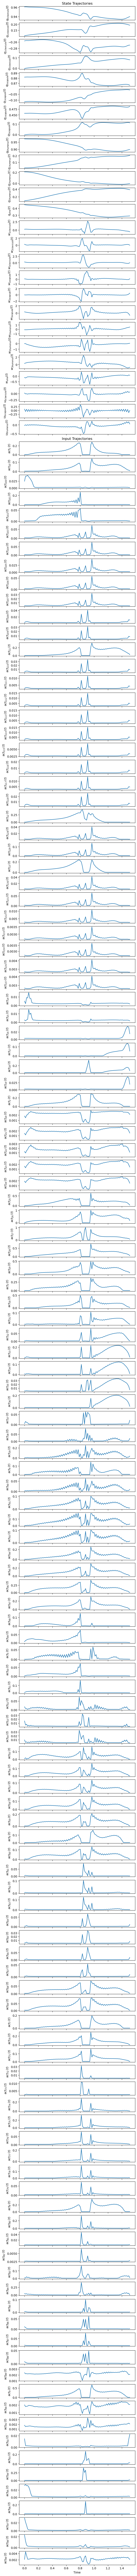

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

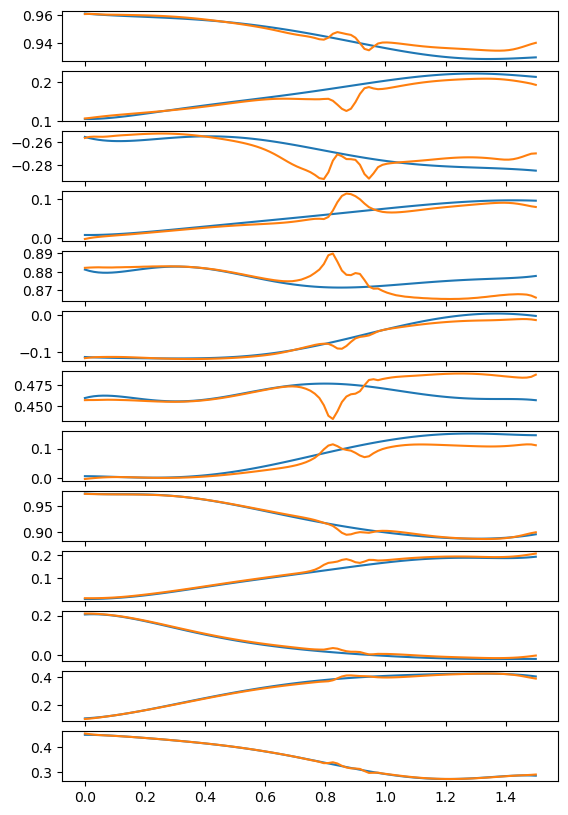

In [29]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(13)
for j in range(13):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

In [30]:
import trajectory_lib as tr
reload (tr);
file_name = '../quat_abd.mat'
tr.sol2struct(solution,activations,len(q),num_states,num_nodes,time,time_2_solve,file_name)

Saved to .mat file


In [ ]:
import trajectory_lib as tr
reload (tr);

file_name_mot = '../quat_abd.mot'
tr.sol2mot_quat(solution,num_nodes,13,time,file_name_mot)